# Predicting Cancer Cells Using Logistic Regression

The goal of this work is to develop a machine learning model to accurately classify cancerous cells as either malignant or benign based on various cellular features. By applying a logistic regression model, we aim to create a predictive system that can assist in early detection of cancer, thus potentially improving patient outcomes. The project involves feature selection, model training, evaluation of performance, and deployment of the model for real-time predictions.

# Connect to the PostgreSQL Database:

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Ignore SQLITE warnings related to Decimal numbers in the database
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import requests
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

db_url = "http://127.0.0.1:5000/api_json_connectivity"
response = requests.get(db_url)
# Check if the request was successful
if response.status_code == 200:
    json_data = response.json()  # Get JSON data
else:
    print(f"Error: {response.status_code}")
    json_data = []
# Step 2: Load the JSON data into a DataFrame
df = pd.DataFrame(json_data)
# Display the first few rows of the DataFrame
df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [3]:
# To get all column names
df.columns

Index(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave points_mean',
       'concave points_se', 'concave points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'diagnosis',
       'fractal_dimension_mean', 'fractal_dimension_se',
       'fractal_dimension_worst', 'id', 'perimeter_mean', 'perimeter_se',
       'perimeter_worst', 'radius_mean', 'radius_se', 'radius_worst',
       'smoothness_mean', 'smoothness_se', 'smoothness_worst', 'symmetry_mean',
       'symmetry_se', 'symmetry_worst', 'texture_mean', 'texture_se',
       'texture_worst'],
      dtype='object')

In [4]:
# Get the number of columns
df.shape[1]

32

In [113]:
# To check if there are any missing values in each column
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

No missing value in dataset

In [114]:
# Find duplicate rows (returns a boolean series indicating whether each row is a duplicate)
duplicates = df.duplicated()

# Count the number of duplicate rows
df.duplicated().sum()

0

No duplicates found in the dataset

In [115]:
# Check the data types of the columns
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In this dataset there is only one categorial variable "diagnosis". The rest of the columns are numerical variables.

In [116]:
# Get the unique values in the 'diagnosis' column
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

This shows distinct values present in the diagnosis column, helping us to understand the categories (such as 'M' for Malignant and 'B' for Benign).

In [117]:
# Display the first few rows of the dataset for further explotation of dataset 
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [118]:
# Get summary statistics (mean, min, max, etc.) for numerical columns to check data distribution
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<Figure size 2000x1500 with 0 Axes>

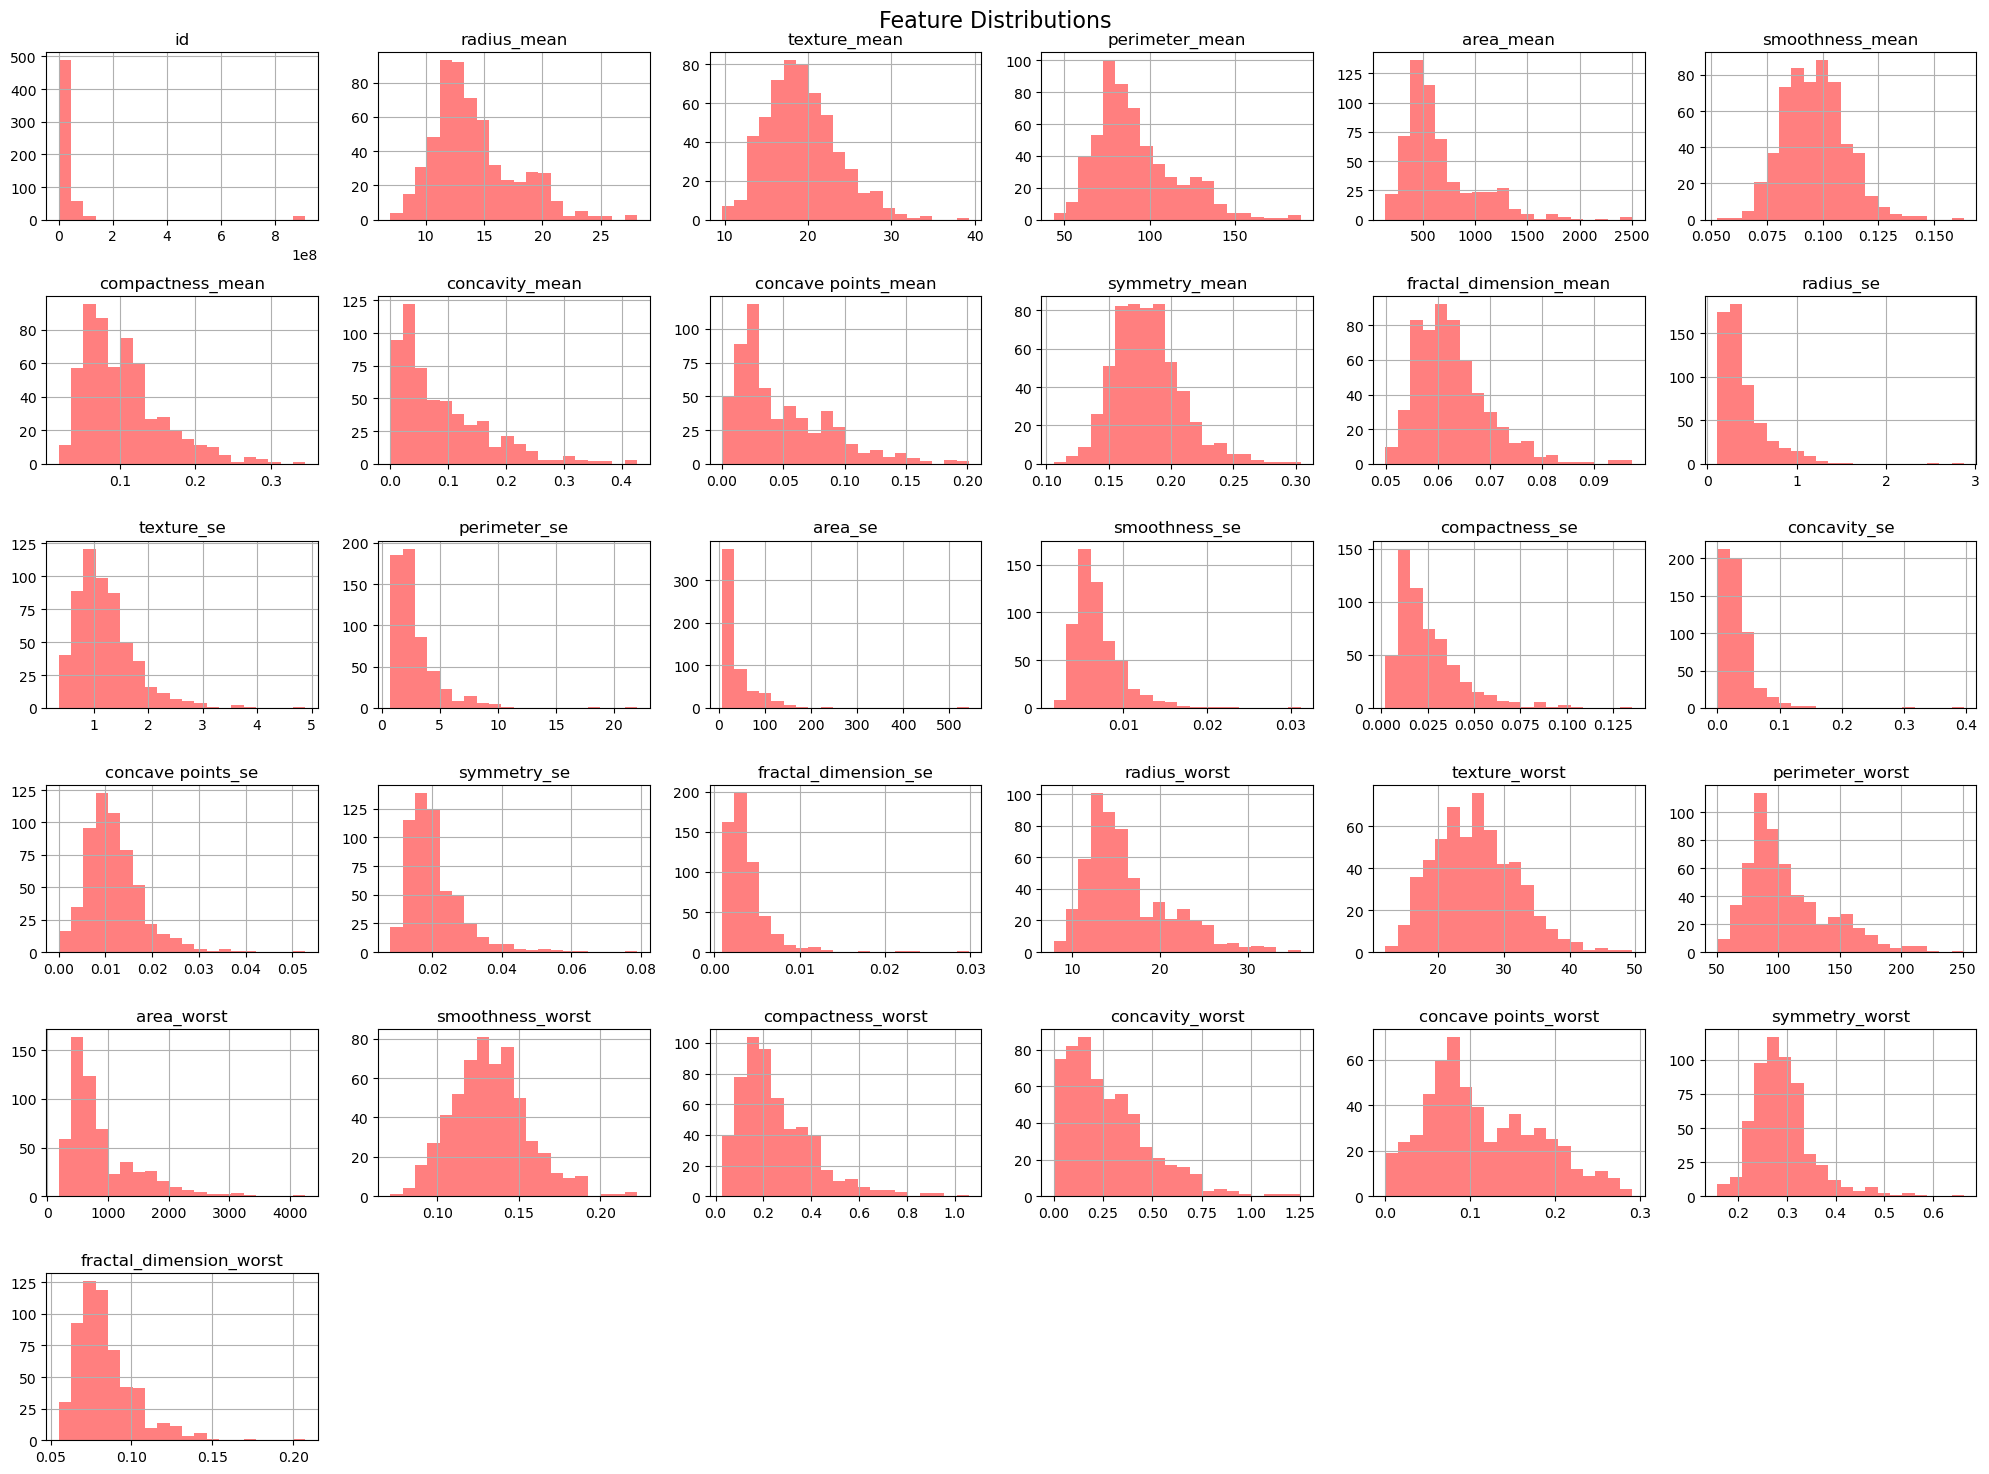

In [119]:
#Check Feature Distributions.

# Plot distributions for malignant cases
plt.figure(figsize=(20, 15))
df.drop(columns=['diagnosis']).hist(bins=20, color='red', alpha=0.5, figsize=(20, 15))
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

Skewness can often be identified by looking at the histograms of the features.According to above grapgh right skewness can be observed for some features. Since some models are sentive to skewness and outliers this should be handled before splitting the data to train and test.

# Data cleaning and Feature Engineering

In [120]:
# Drop 'Unnamed: 32' and 'id' columns since they are not useful
df_cleaned = df.drop(columns=['id'])

# Check the data types of the columns
df_cleaned.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [121]:
# Diagnosis coloumn is objective. Convert this column to numerical values
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].map({'M': 1, 'B': 0})

# Split the data into malignant and benign cases
df_malignant = df_cleaned[df_cleaned['diagnosis'] == 1]
df_benign = df_cleaned[df_cleaned['diagnosis'] == 0]

df_cleaned.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [122]:
# To get summary statistics (mean, min, max, etc.) for numerical columns
df_cleaned.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [123]:
# Check skewness of all features
df_cleaned.skew()

diagnosis                  0.528461
radius_mean                0.942380
texture_mean               0.650450
perimeter_mean             0.990650
area_mean                  1.645732
smoothness_mean            0.456324
compactness_mean           1.190123
concavity_mean             1.401180
concave points_mean        1.171180
symmetry_mean              0.725609
fractal_dimension_mean     1.304489
radius_se                  3.088612
texture_se                 1.646444
perimeter_se               3.443615
area_se                    5.447186
smoothness_se              2.314450
compactness_se             1.902221
concavity_se               5.110463
concave points_se          1.444678
symmetry_se                2.195133
fractal_dimension_se       3.923969
radius_worst               1.103115
texture_worst              0.498321
perimeter_worst            1.128164
area_worst                 1.859373
smoothness_worst           0.415426
compactness_worst          1.473555
concavity_worst            1

How to Decide Which Features to Transform: High skewness values (greater than 1 or less than -1) indicate that a feature should be transformed. Mild skewness (between -1 and 1) may not require transformation, but we can still experiment if needed. Based on the skewness values we considered transforming the following highly skewed features:
area_se (skewness = 5.45) concavity_se (skewness = 5.11) perimeter_se (skewness = 3.44) radius_se (skewness = 3.09) fractal_dimension_se (skewness = 3.92)

In [124]:
# Features to transform based on high skewness
features_to_transform = ['area_se', 'concavity_se', 'perimeter_se', 'radius_se', 'fractal_dimension_se']

# Apply log1p (log(1 + x)) transformation
for feature in features_to_transform:
    df_cleaned[feature + '_log'] = np.log1p(df_cleaned[feature])


In [125]:
# Define the names of the log-transformed columns
transformed_columns = [feature + '_log' for feature in features_to_transform]

# Check skewness of the log-transformed columns
log_transformed_skewness = df_cleaned[transformed_columns].skew()

# Display the skewness values
print(log_transformed_skewness)

area_se_log                 0.847298
concavity_se_log            4.231738
perimeter_se_log            1.025375
radius_se_log               1.713417
fractal_dimension_se_log    3.874373
dtype: float64


In [126]:
df_cleaned.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.6656,0.7119,0.2654,0.4601,0.11890,5.039547,0.052336,2.260617,0.739554,0.006174
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.1866,0.2416,0.1860,0.2750,0.08902,4.318554,0.018429,1.481150,0.434053,0.003526
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.4245,0.4504,0.2430,0.3613,0.08758,4.554193,0.037604,1.720084,0.557098,0.004561
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.8663,0.6869,0.2575,0.6638,0.17300,3.340385,0.055066,1.491780,0.402527,0.009166
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.2050,0.4000,0.1625,0.2364,0.07678,4.558498,0.055321,1.862218,0.563722,0.005102


In [127]:
# List of the original columns to be removed
columns_to_drop = features_to_transform  # These are the original columns before the log transformation

# Drop the original columns from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Check the DataFrame to ensure columns have been removed
df_cleaned.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.6656,0.7119,0.2654,0.4601,0.11890,5.039547,0.052336,2.260617,0.739554,0.006174
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.1866,0.2416,0.1860,0.2750,0.08902,4.318554,0.018429,1.481150,0.434053,0.003526
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.4245,0.4504,0.2430,0.3613,0.08758,4.554193,0.037604,1.720084,0.557098,0.004561
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.8663,0.6869,0.2575,0.6638,0.17300,3.340385,0.055066,1.491780,0.402527,0.009166
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.2050,0.4000,0.1625,0.2364,0.07678,4.558498,0.055321,1.862218,0.563722,0.005102


In [128]:
# Define the columns to rename
columns_to_rename = {
    'area_se_log': 'area_se',
    'concavity_se_log': 'concavity_se',
    'perimeter_se_log': 'perimeter_se',
    'radius_se_log': 'radius_se',
    'fractal_dimension_se_log': 'fractal_dimension_se'
}

# Renaming the columns in the DataFrame
df_cleaned.rename(columns=columns_to_rename, inplace=True)

# Display the updated column names to verify the changes
df_cleaned.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.6656,0.7119,0.2654,0.4601,0.11890,5.039547,0.052336,2.260617,0.739554,0.006174
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,0.1866,0.2416,0.1860,0.2750,0.08902,4.318554,0.018429,1.481150,0.434053,0.003526
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.4245,0.4504,0.2430,0.3613,0.08758,4.554193,0.037604,1.720084,0.557098,0.004561
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.8663,0.6869,0.2575,0.6638,0.17300,3.340385,0.055066,1.491780,0.402527,0.009166
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,0.2050,0.4000,0.1625,0.2364,0.07678,4.558498,0.055321,1.862218,0.563722,0.005102


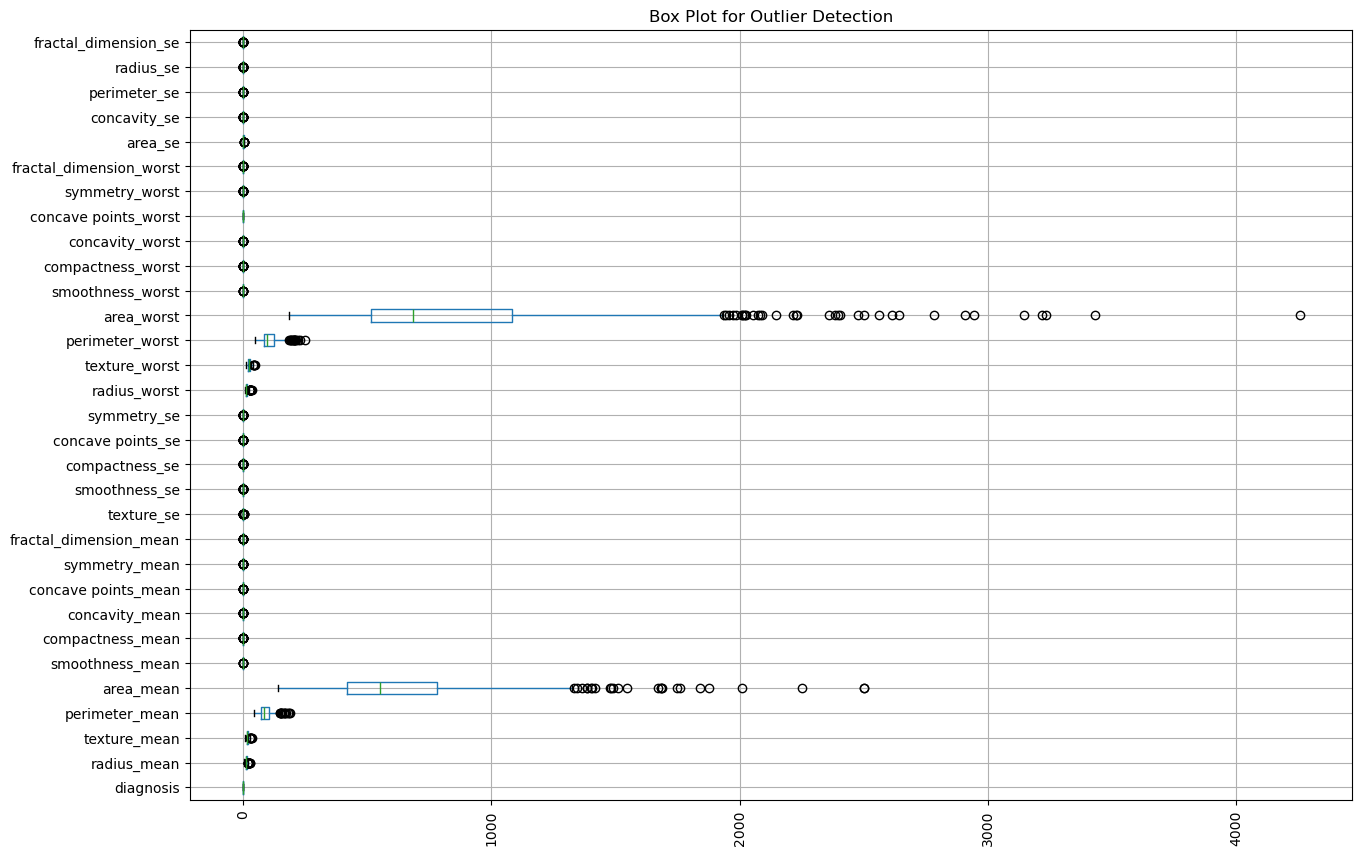

In [129]:
# check outliers and remove or cap. 
# Create boxplots for all the numerical features to detect outliers
df_cleaned.boxplot(figsize=(15, 10), vert=False)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Box Plot for Outlier Detection")
plt.show()

Features that has major Outliers are area_worst perimeter_worst area_mean perimeter_mean
We capped these outliers by replacing values outside the 1st and 99th percentiles with the values at those percentiles.

In [130]:
# Define the features that have major outliers
features_with_outliers = ['area_worst', 'perimeter_worst', 'area_mean', 'perimeter_mean']

# Cap outliers at 1st and 99th percentiles
for feature in features_with_outliers:
    lower_cap = df_cleaned[feature].quantile(0.01)  # 1st percentile
    upper_cap = df_cleaned[feature].quantile(0.99)  # 99th percentile
    
    # Cap the values in the original DataFrame
    df_cleaned[feature] = df_cleaned[feature].clip(lower=lower_cap, upper=upper_cap)

# Check the data after capping outliers
df_cleaned[features_with_outliers].describe()

,area_worst,perimeter_worst,area_mean,perimeter_mean
count,569.000000,569.000000,569.000000,569.000000
mean,876.073835,107.132718,651.295227,91.889771
std,548.004368,33.020473,334.962197,23.752853
min,256.192000,58.270400,215.664000,53.827600
25%,515.300000,84.110000,420.300000,75.170000
50%,686.500000,97.660000,551.100000,86.240000
75%,1084.000000,125.400000,782.700000,104.100000
max,2918.160000,208.304000,1786.600000,165.724000


Use this cleaned data to pplit into Training and Test Sets, scaling and training using different models.

# Logistic Regression: A simple and interpretable model for binary classification.

# 1. Create the labels set (y) from the “diagnosis” column, and then create the features (X) DataFrame from the remaining columns

In [131]:
# Define X (features) and y (target label)
X = df_cleaned.drop('diagnosis', axis=1)  # Features
y = df_cleaned['diagnosis']  # Target

In [132]:
# Review the y variable Series
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [133]:
# Review the X variable DataFrame
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,0.6656,0.7119,0.2654,0.4601,0.11890,5.039547,0.052336,2.260617,0.739554,0.006174
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.1866,0.2416,0.1860,0.2750,0.08902,4.318554,0.018429,1.481150,0.434053,0.003526
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,0.4245,0.4504,0.2430,0.3613,0.08758,4.554193,0.037604,1.720084,0.557098,0.004561
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,0.8663,0.6869,0.2575,0.6638,0.17300,3.340385,0.055066,1.491780,0.402527,0.009166
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,0.2050,0.4000,0.1625,0.2364,0.07678,4.558498,0.055321,1.862218,0.563722,0.005102


# 2.Split the data into training and testing datasets by using train_test_split

In [134]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,stratify=y)

X_train.shape

(426, 30)

In [135]:
# For training data
print("Training data distribution:")
print(y_train.value_counts())

# For test data
print("\nTest data distribution:")
print(y_test.value_counts())

Training data distribution:
diagnosis
0    267
1    159
Name: count, dtype: int64

Test data distribution:
diagnosis
0    90
1    53
Name: count, dtype: int64


# 3.Scale the Data

In [136]:
# Initialize the scaler
scaler = StandardScaler()

In [137]:
# Step 3: Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Step 4: Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

# save the scaler
joblib.dump(scaler, 'scaler_reduced.pkl')
print("Scaler saved successfully!")


Scaler saved successfully!


# 4. Initialize the Logistic Regression model

In [138]:
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Fit the model on the scaled training data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=1)

# Save the predictions on the testing data labels by using the testing feature data (X_test_scaled) and the fitted model.¶

In [139]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test_scaled)
Results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
Results.head(10)

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [140]:
# Calculate accuracy score
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy formatted to four decimal places
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9720


Evaluate the model’s performance by doing the following: Generate a confusion matrix. Print the classification report.

In [141]:
# Create and save the confusion matrix for the testing data
confusion_matrix(y_test, predictions)

array([[89,  1],
       [ 3, 50]])

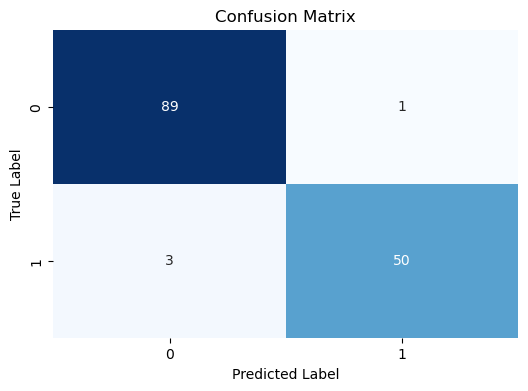

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [143]:
# Create and save the testing classification report
testing_report = classification_report(y_test, predictions)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



Results: 

The Logistic Regression model is performing very well in predicting both the 0 (benign) and 1 (malignant) labels based on the classification report you provided.

The model is excellent at predicting both benign (class 0) and malignant (class 1) cases. Precision and Recall are high for both classes, with almost perfect performance for benign cases (class 0) and very strong performance for malignant cases (class 1). The F1-Scores are also high, indicating a good balance between precision and recall, with few false positives or false negatives.
To further optimize the model we used GridSearch.  

# Hyperparameter tune the Logistic Regression model to optimize its performance

In [147]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear'],      # Optimization solvers
    'penalty': ['l2'],                     # Regularization type (l2 is default, l1 is for certain solvers)
    'max_iter': [100, 200, 300]            # Maximum number of iterations
}

# Instantiate the Logistic Regression model
log_reg = LogisticRegression(random_state=1)

# Initialize GridSearchCV with cross-validation (cv=5 means 5-fold cross-validation)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters for Logistic Regression:", best_params)

# Train the Logistic Regression model with the best parameters
best_log_reg = grid_search.best_estimator_

# Make predictions
y_pred_best_log_reg = best_log_reg.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_best_log_reg))
print(classification_report(y_test, y_pred_best_log_reg))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Logistic Regression: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned Logistic Regression Results:
[[89  1]
 [ 3 50]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



Performance Before and After Tuning:
The model showed similar performance before and after tuning, with precision, recall, and F1-scores remaining nearly identical for both classes. The overall accuracy of the model remained steady at 97%, indicating that the logistic regression model was already performing well even before tuning.

In [149]:
#pip install joblib. 

import joblib

# Save the best model from GridSearchCV
joblib.dump(best_log_reg, 'best_logistic_regression_model.pkl')

['best_logistic_regression_model.pkl']

In [150]:
# Load the saved model
loaded_model = joblib.load('best_logistic_regression_model.pkl')

# Making predictions on sample data

In [152]:
# Eg 1: 
#Create a sample input for prediction 
# This sample input is similar to one row from OUR dataset, without the ID and diagnosis columns
sample_input = np.array([
    [
        17.99, 10.38, 122.80, 1001.0, 0.11840, 0.27760, 0.3001, 0.14710,
        0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 
        0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.60, 2019.0, 
        0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.11890
    ]
])

# Use the loaded model to make predictions
prediction = loaded_model.predict(sample_input)

# Print the prediction result
print(f"Predicted class: {prediction[0]}")

Predicted class: 1


In [153]:
#Eg 2: 

# Step 1: Remove 'ID' and 'diagnosis' columns from the dataset
df_cleaned = df_cleaned.drop(columns=['id', 'diagnosis'], errors='ignore')

# Step 2: Extract the 20th row (index 19, as indexing starts at 0)
random_row_selected = df_cleaned.iloc[19]

# Step 3: Convert the row to a numpy array and reshape it for prediction
sample_input = random_row_selected.values.reshape(1, -1)

# Step 4: Scale the input (using the same scaler used during training)
sample_input_scaled = scaler.transform(sample_input)

# Step 5: Use the loaded model to make predictions
prediction = loaded_model.predict(sample_input_scaled)

# Step 6: Print the prediction result
print(f"Predicted class: {prediction[0]}")

Predicted class: 0


# Feature Selection

Recursive Feature Elimination (RFE) eliminates features iteratively by fitting the logistic regression model, leaving only the most important ones.

After performing Grid Search to find the best hyperparameters for Logistic Regression model, then we performed  feature selection using Recursive Feature Elimination (RFE). RFE can recursively eliminate the least important features until the specified number of features is reached.

In [154]:
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report

# Use RFE with index-based selection 
rfe = RFE(estimator=best_log_reg, n_features_to_select=11)
rfe.fit(X_train_scaled, y_train)

# Get the indices of the selected features
selected_feature_indices = rfe.support_

# Select features using the indices
X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]

# Train the model again with selected features
best_log_reg.fit(X_train_selected, y_train)

# Make predictions
y_pred_selected = best_log_reg.predict(X_test_selected)

# Evaluate the model
print(confusion_matrix(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))



[[89  1]
 [ 4 49]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.98      0.92      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



In [155]:
# Get the boolean mask of the selected features
selected_feature_indices = rfe.support_

# Retrieve the names of the selected features from the original columns
selected_feature_names = X_train.columns[selected_feature_indices]

# Print the selected feature names
print("Selected Features by RFE:")
print(selected_feature_names)

Selected Features by RFE:
Index(['texture_mean', 'concave points_mean', 'compactness_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'concavity_worst', 'area_se', 'radius_se'],
      dtype='object')


In [156]:
# Save the best logistic regression model after feature selection
joblib.dump(best_log_reg, 'FeatureReduced_logistic_regression_model.pkl')

['FeatureReduced_logistic_regression_model.pkl']

In [157]:
# Load the saved logistic regression model
loaded_model = joblib.load('FeatureReduced_logistic_regression_model.pkl')

# Making predictions on sample data using reduced features.

In [161]:
# List of selected features from RFE
selected_features = ['area_mean', 'concave points_mean', 'radius_worst', 'texture_worst',
                     'perimeter_worst', 'area_worst', 'smoothness_worst', 
                     'concave points_worst', 'symmetry_worst', 'area_se', 'radius_se']

# Extract the first row and filter for selected features
first_row_selected = df[selected_features].iloc[0]

print(first_row_selected)

area_mean               1001.0000
concave points_mean        0.1471
radius_worst              25.3800
texture_worst             17.3300
perimeter_worst          184.6000
area_worst              2019.0000
smoothness_worst           0.1622
concave points_worst       0.2654
symmetry_worst             0.4601
area_se                  153.4000
radius_se                  1.0950
Name: 0, dtype: float64


In [162]:

# Fit a new scaler on the reduced training set (only the selected features)
scaler_reduced = StandardScaler()

# Assuming X_train is your full training set and you've reduced it to selected features
X_train_reduced = X_train[selected_features]

# Fit the scaler on the reduced training set
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)

#Save the new scaler to a file for use in the Flask app
joblib.dump(scaler_reduced, 'scaler_reduced.pkl')

print("Scaler fitted on 11 selected features and saved as 'scaler_reduced.pkl'")

Scaler fitted on 11 selected features and saved as 'scaler_reduced.pkl'


In [163]:
# Now apply the scaler to the selected row (1st row)
sample_input_reduced = df_cleaned[selected_features].iloc[0].values.reshape(1, -1)
sample_input_scaled = scaler_reduced.transform(sample_input_reduced)

# Print the scaled first row
print(sample_input_scaled)

[[ 1.02009076  2.49876474  1.83069803 -1.40835142  2.29160801  2.02369318
   1.2760072   2.27495883  2.67885852  2.23223583  2.37584575]]


In [164]:
# Make a prediction using the scaled input row

#Eg:1
# Make a prediction (for example, using the scaled first row)
prediction = best_log_reg.predict(sample_input_scaled)

# Print the prediction result
print("Prediction for the first row:", prediction)


Prediction for the first row: [1]


In [107]:
#Eg:2

# Select the 20th row and filter for selected features
sample_input_20th = df_cleaned[selected_features].iloc[19].values.reshape(1, -1)  
# Scale the 20th row using the previously fitted scaler
sample_input_20th_scaled = scaler_reduced.transform(sample_input_20th)

# Make a prediction using the scaled 20th row
prediction_20th = best_log_reg.predict(sample_input_20th_scaled)

# Print the prediction for the 20th row
print("Prediction for the 20th row:", prediction_20th)


Prediction for the 20th row: [0]


After applying feature selection techniques, we observed that the performance of the model trained on the reduced set of features was equivaly predicing as the model trained on the full set of features. 
Thefore, we decided to move forward with the feature-reduced model for the app development. This choice not only simplifies the model but also reduces computational complexity, making it faster and more efficient for real-time predictions in our web application.